In [1]:
!pip install geopy shapely
!pip install folium
!pip install osmnx
!pip install geopandas matplotlib contextily folium

In [2]:
import networkx as nx
import osmnx as ox
import numpy as np
import pandas as pd
from pyproj import Transformer
import os
import glob
from shapely.geometry import Point
from geopandas import GeoDataFrame

In [3]:
Leeds_centre = (53.8008, -1.5491)
G = ox.graph_from_point(Leeds_centre, dist=600, network_type='drive', simplify=True)

In [4]:
G_proj = ox.project_graph(G)

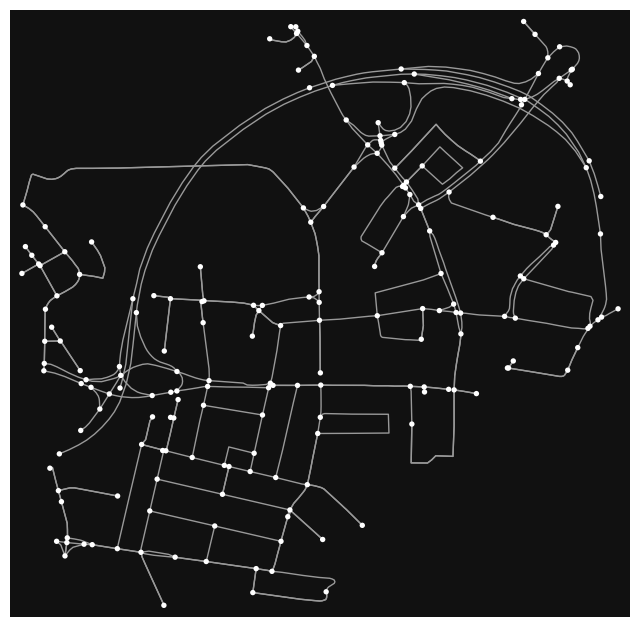

(<Figure size 800x800 with 1 Axes>, <AxesSubplot: >)

In [5]:
ox.plot_graph(G_proj)

In [6]:
# Get node points
node_points = [Point(data['x'], data['y']) for _, data in G_proj.nodes(data=True)]

# Create a GeoDataFrame
gdf_nodes = GeoDataFrame({'geometry': node_points}, crs=G_proj.graph['crs'])

# Calculate the convex hull
convex_hull = gdf_nodes.unary_union.convex_hull

# Calculate area in square kilometers
area_km2 = convex_hull.area / 1e6
print(f"Area covered: {area_km2:} square kilometers")

Area covered: 1.0494393810667353 square kilometers


In [7]:
is_planar, counterexample = nx.check_planarity(
    G_proj, counterexample=True)
is_planar

False

In [8]:
counterexample

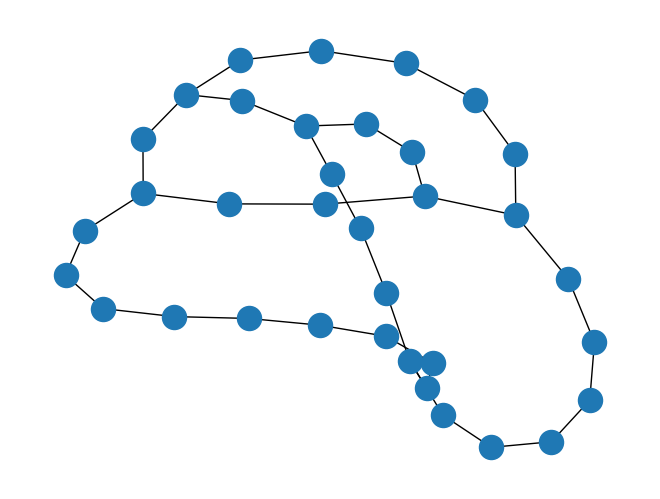

In [9]:
nx.draw(counterexample)

In [10]:
lengths = dict(nx.all_pairs_dijkstra_path_length(G_proj, weight='length'))

# Find the maximum length (i.e., the spatial diameter)
spatial_diameter = max(max(length.values()) for length in lengths.values())
print("Spatial Diameter of the Network:", spatial_diameter, "meters")

Spatial Diameter of the Network: 3807.405 meters


In [11]:
# Calculate the total length of all streets
total_length = sum(d['length'] for u, v, d in G_proj.edges(data=True))

# Count the total number of street segments
total_streets = len(G_proj.edges())

# Calculate the average street length
average_street_length = total_length / total_streets
print("Average Street Length:", average_street_length, "meters")

Average Street Length: 76.39348450704232 meters


In [12]:
total_nodes = len(G_proj.nodes())
node_density = total_nodes / area_km2

print(f"Node Density: {node_density} nodes per square kilometer")

Node Density: 188.67216494080557 nodes per square kilometer


In [13]:
total_edge_length = sum(nx.get_edge_attributes(G_proj, 'length').values())


area_km2 = convex_hull.area / 1e6
edge_density = total_edge_length / area_km2

print(f"Total Edge Length: {total_edge_length} meters")
print(f"Edge Density: {edge_density} meters per square kilometer")

Total Edge Length: 27119.68700000002 meters
Edge Density: 25842.071004075882 meters per square kilometer


In [14]:
CRIMES_DIR = "Question_data"
USE_COLS = ['Reference Number', 'Grid Ref: Easting', 'Grid Ref: Northing']
df = [pd.read_csv(csv_file, usecols=USE_COLS, encoding='latin1') \
             for path, subdir, _ in os.walk(CRIMES_DIR) \
             for csv_file in glob.glob(os.path.join(path, "*.csv"))]
accident_df = pd.concat(df, axis=0, ignore_index=True)
transformer = Transformer.from_crs("epsg:27700", "epsg:4326", always_xy=True)
accident_df['Longitude'], accident_df['Latitude'] = transformer.transform(accident_df['Grid Ref: Easting'].values,
                                                                          accident_df['Grid Ref: Northing'].values)
print("Total no. of crimes loaded: {}".format(len(accident_df)))

Total no. of crimes loaded: 13851


In [15]:
accident_df['distance'] = ((accident_df['Latitude'] - Leeds_centre[0])**2 + (accident_df['Longitude'] - Leeds_centre[1])**2)**0.5 * 111 #degree to km
# Filter accidents within 5 km radius
df_near_leeds = accident_df[accident_df['distance'] <= 5]

In [16]:
from sklearn.cluster import DBSCAN

coords = df_near_leeds[['Latitude', 'Longitude']].values

db = DBSCAN(eps=0.001, min_samples=10).fit(coords)
labels = db.labels_

n_clusters = len(set(labels)) - (1 if -1 in labels else 0)  # Removing noise label
print(f"Number of clusters: {n_clusters}")
print("Cluster labels:", np.unique(labels))

df_near_leeds['cluster'] = labels

# Filter noise points
df_clusters = df_near_leeds[df_near_leeds['cluster'] != -1]

# Add cluster to the dataframe
df_near_leeds['cluster'] = db

most_accidents_cluster = df_clusters['cluster'].value_counts().idxmax()
cluster_center = df_clusters[df_clusters['cluster'] == most_accidents_cluster][['Latitude', 'Longitude']].mean()
print(f"Cluster center with most accidents: {cluster_center}")

Number of clusters: 111
Cluster labels: [ -1   0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16
  17  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34
  35  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52
  53  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70
  71  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88
  89  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106
 107 108 109 110]
Cluster center with most accidents: Latitude     53.796905
Longitude    -1.540826
dtype: float64


/var/folders/jm/kdm_dw8123b0_rn021mc53f80000gn/T/ipykernel_34617/1740864461.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_near_leeds['cluster'] = labels
/var/folders/jm/kdm_dw8123b0_rn021mc53f80000gn/T/ipykernel_34617/1740864461.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_near_leeds['cluster'] = db


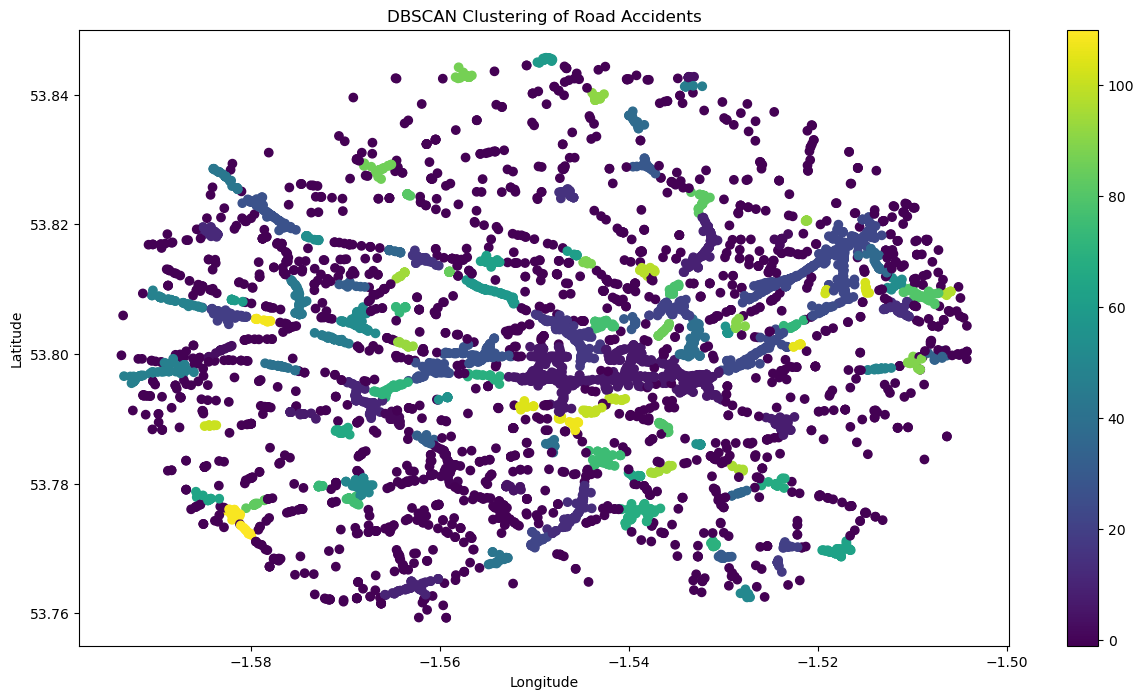

In [17]:
import matplotlib.pyplot as plt

# Plotting
plt.figure(figsize=(15, 8))
scatter = plt.scatter(df_near_leeds['Longitude'], df_near_leeds['Latitude'], c=labels, cmap='viridis', label=labels)
plt.title('DBSCAN Clustering of Road Accidents')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.colorbar(scatter)
plt.show()

In [18]:
unique_labels, counts = np.unique(labels, return_counts=True)
cluster_info_np = dict(zip(unique_labels, counts))
print("Cluster info (NumPy):", cluster_info_np)
print(cluster_info_np.values())

Cluster info (NumPy): {-1: 1886, 0: 90, 1: 19, 2: 11, 3: 15, 4: 11, 5: 22, 6: 570, 7: 26, 8: 37, 9: 112, 10: 67, 11: 76, 12: 21, 13: 83, 14: 31, 15: 22, 16: 46, 17: 138, 18: 12, 19: 56, 20: 10, 21: 69, 22: 35, 23: 453, 24: 91, 25: 22, 26: 73, 27: 76, 28: 119, 29: 20, 30: 18, 31: 18, 32: 15, 33: 12, 34: 12, 35: 12, 36: 26, 37: 23, 38: 21, 39: 95, 40: 14, 41: 24, 42: 21, 43: 37, 44: 56, 45: 38, 46: 11, 47: 61, 48: 36, 49: 14, 50: 33, 51: 10, 52: 45, 53: 13, 54: 18, 55: 11, 56: 12, 57: 16, 58: 57, 59: 18, 60: 10, 61: 11, 62: 19, 63: 49, 64: 14, 65: 16, 66: 16, 67: 24, 68: 53, 69: 24, 70: 28, 71: 38, 72: 18, 73: 12, 74: 12, 75: 39, 76: 24, 77: 26, 78: 18, 79: 17, 80: 39, 81: 14, 82: 31, 83: 13, 84: 17, 85: 19, 86: 29, 87: 25, 88: 14, 89: 15, 90: 11, 91: 12, 92: 11, 93: 10, 94: 11, 95: 15, 96: 10, 97: 8, 98: 10, 99: 10, 100: 14, 101: 10, 102: 7, 103: 10, 104: 10, 105: 8, 106: 8, 107: 11, 108: 14, 109: 10, 110: 10}
dict_values([1886, 90, 19, 11, 15, 11, 22, 570, 26, 37, 112, 67, 76, 21, 83, 

In [19]:
import itertools

total_distance = 0
for node1, node2 in itertools.combinations(G.nodes(), 2):
    try:
        path_length = nx.shortest_path_length(G, source=node1, target=node2, weight='length')
        total_distance += path_length
    except nx.NetworkXNoPath:
        continue

print("Total distance of shortest paths for all pairs:", total_distance)

Total distance of shortest paths for all pairs: 19569762.867999937


In [20]:
from geopy.distance import geodesic

nodes = G.nodes(data=True)  # This contains all node data including coordinates

node_pairs = [(node1, node2) for node1, node2 in zip(list(G.nodes())[::10], list(G.nodes())[1::10])]

total_direct_distance = 0

for node1, node2 in node_pairs:
    coords_1 = (nodes[node1]['y'], nodes[node1]['x'])  # Lat, Lon for node1
    coords_2 = (nodes[node2]['y'], nodes[node2]['x'])  # Lat, Lon for node2

    # geodesic distance
    distance = geodesic(coords_1, coords_2).meters
    total_direct_distance += distance

print("Total direct distance for selected pairs:", total_direct_distance)

Total direct distance for selected pairs: 7783.606091792509


In [21]:
import itertools

total_direct_distance = 0
for node1, node2 in itertools.combinations(G.nodes(), 2):
    # Access attributes directly from nodes dictionary
    coords_1 = (G.nodes[node1]['y'], G.nodes[node1]['x'])  # Ensure nodes[node1] is used correctly
    coords_2 = (G.nodes[node2]['y'], G.nodes[node2]['x'])

    # Calculate geodesic distance
    distance = geodesic(coords_1, coords_2).meters
    total_direct_distance += distance

print("Total direct distance:", total_direct_distance)

Total direct distance: 11081701.306572333


In [22]:
print(total_distance/total_direct_distance)

1.7659529278589656
